In [ ]:
!pip install simpy

In [ ]:
import simpy
import random
import statistics
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
def get_user_input():
    num_leecher = input("Input # of Leecher working: ")
    num_seeder = input("Input # of seeder working: ")

    params = [num_leecher, num_seeder]
    if all(str(i).isdigit() for i in params):  # Check input is valid
        params = [int(x) for x in params]
    else:
        print(
            "Could not parse input. Simulation will use default values:",
            "\n1 cashier, 1 server, 1 usher.",
        )
        params = [1, 1]
    return params

In [ ]:
class bittorentNetwork(object):
    def __init__(self, env, num_leecher):
      self.env = env
      self.leecher = simpy.Resource(env, num_leecher)


In [ ]:

TOTAL_PIECES = 10  # 总共的文件块数 / Total number of file pieces
SIMULATION_TIME = 100  # 模拟的总时长 / Total simulation time
nOfPeers=0;

class Peer:
    def __init__(self, env, id, upload_speed, download_speed):
        self.env = env
        self.id = id
        self.upload_speed = upload_speed  # 上传带宽 / Upload bandwidth
        self.download_speed = download_speed  # 下载带宽 / Download bandwidth
        self.file_pieces = set()  # 当前拥有的文件块 / File pieces currently owned
        self.peers = []  # 其他对等节点 / Other peers
        self.upload_resource = simpy.Resource(env, capacity=upload_speed)  # 上传带宽作为资源 / Upload bandwidth as a resource
        self.current_requests = 0  # 当前的请求数 / Current number of requests
        self.env.process(self.run())

    def add_peer(self, peer):
        self.peers.append(peer)

    def request_piece(self, piece, target):
        """请求特定文件块并动态调整带宽 / Request a specific file piece and dynamically adjust bandwidth"""
        # 检查目标节点是否仍然拥有该文件块 / Check if the target peer still has the requested file piece
        if piece in target.file_pieces:
            print(f'Time {self.env.now}: Peer {self.id} requests file piece {piece} from Peer {target.id}')

            # 请求目标节点的上传带宽资源 / Request the target peer's upload bandwidth resource
            with target.upload_resource.request() as req:
                # yield req
                # 等待资源可用 / Wait until the resource is available
                # 在下载开始时增加目标节点的请求数 / Increase the target peer's request count at the start of download
                target.current_requests += 1

                # 文件块大小 / Size of file piece
                piece_size = Peer.piece_size  # 假设每个文件块大小为 1 / Assume each file piece size is 1
                downloaded = 0  # 初始化已下载部分 / Initialize downloaded portion

                # 以较小的时间步进行下载，动态调整带宽 / Download the piece in smaller steps, adjusting bandwidth dynamically
                while downloaded < piece_size:
                    # 当前的请求数（可能动态变化） / Current number of requests (may change dynamically)
                    number_of_requests = target.current_requests

                    # 计算每个请求的可用带宽 / Calculate available bandwidth per request
                    available_bandwidth_per_request = target.upload_speed / max(1, number_of_requests)

                    # 每个时间步下载的数据量 / Amount of data downloaded per time step
                    data_per_step = available_bandwidth_per_request * 0.1  # 假设时间步为 0.1 秒 / Assume time step is 0.1 seconds

                    # 增加已下载的数据量 / Increase downloaded data
                    downloaded += data_per_step

                    # 模拟时间步 / Simulate the time step
                    yield self.env.timeout(0.1)

                    # 输出下载进度 / Print download progress
                    progress_percentage = (downloaded / piece_size) * 100
                    print(f'Time {self.env.now:.1f}: Peer {self.id} has downloaded {progress_percentage:.1f}% of file piece {piece}')
                # 下载完成后减少目标节点的请求数 / Decrease the target peer's request count after download
                target.current_requests -= 1

                # 下载完成后添加文件块 / Add the completed file piece to the owned set
                self.file_pieces.add(piece)
                print(f'Time {self.env.now:.1f}: Peer {self.id} completed download of file piece {piece}')
        else:
            # 目标节点已经没有这个文件块 / Target peer no longer has the file piece
            print(f"Time {self.env.now:.1f}: Peer {self.id} found that Peer {target.id} no longer has file piece {piece}")

    def run(self):
        while True:
            # 如果所有文件块已下载，停止请求 / Stop requesting if all file pieces are downloaded
            if len(self.file_pieces) == TOTAL_PIECES:
                print(f'Peer {self.id} has completed downloading all file pieces, stopping requests')
                break

            yield self.env.timeout(1)  # 每个时间步执行一次 / Execute once per time step

            # 查找当前节点缺少的文件块 / Find the file pieces that the current peer is missing
            missing_pieces = set(range(TOTAL_PIECES)) - self.file_pieces
            if not missing_pieces:
                break

            # 创建一个并行任务的列表 / Create a list of parallel tasks
            request_tasks = []

            # 创建一个"正在请求的文件块"集合，避免重复请求 / Create a set of "file pieces being requested" to avoid duplicate requests
            requesting_pieces = set()

            # 遍历每个缺少的文件块，找到拥有该文件块的对等节点 / Iterate over each missing file piece and find peers that have it
            for piece in missing_pieces:
                # 如果该块已经被请求，则跳过 / Skip if this piece is already being requested
                if piece in requesting_pieces:
                    continue
                shuffled_peers = self.peers[:]
                random.shuffle(shuffled_peers)  # 我把shuffle放在这里，因为我不想让id小的peer有更高的请求优先级 / I put shuffle here because I don't want peers with small IDs to have higher request priority

                # 遍历打乱后的节点顺序 / Iterate over shuffled peers
                for target_peer in shuffled_peers:
                    if piece in target_peer.file_pieces:
                        # 找到拥有该块的对等节点后，发起请求 / Once a peer with the piece is found, request it
                        request_tasks.append(self.env.process(self.request_piece(piece, target_peer)))

                        # 将该文件块加入到"正在请求的文件块"集合中 / Add the piece to the "requesting pieces" set
                        requesting_pieces.add(piece)

                        break  # 找到一个目标后退出该块的搜索 / Exit the loop for this piece once a peer is found

            # 并行处理多个请求 / Process all parallel requests
            if request_tasks:
                yield self.env.all_of(request_tasks)  # 并行执行所有请求任务 / Execute all request tasks in parallel

Peer 0 has completed downloading all file pieces, stopping requests
Time 1: Peer 1 requests file piece 8 from Peer 4
Time 1: Peer 1 requests file piece 3 from Peer 3
Time 1: Peer 1 requests file piece 4 from Peer 0
Time 1: Peer 2 requests file piece 0 from Peer 1
Time 1: Peer 2 requests file piece 3 from Peer 3
Time 1: Peer 2 requests file piece 4 from Peer 4
Time 1: Peer 2 requests file piece 7 from Peer 1
Time 1: Peer 3 requests file piece 0 from Peer 1
Time 1: Peer 3 requests file piece 1 from Peer 0
Time 1: Peer 3 requests file piece 4 from Peer 4
Time 1: Peer 3 requests file piece 5 from Peer 4
Time 1: Peer 3 requests file piece 7 from Peer 4
Time 1: Peer 3 requests file piece 8 from Peer 4
Time 1: Peer 3 requests file piece 9 from Peer 0
Time 1: Peer 4 requests file piece 1 from Peer 1
Time 1: Peer 4 requests file piece 2 from Peer 2
Time 1.1: Peer 1 has downloaded 4.2% of file piece 8
Time 1.1: Peer 1 has downloaded 3.3% of file piece 3
Time 1.1: Peer 1 has downloaded 8.4% of fi

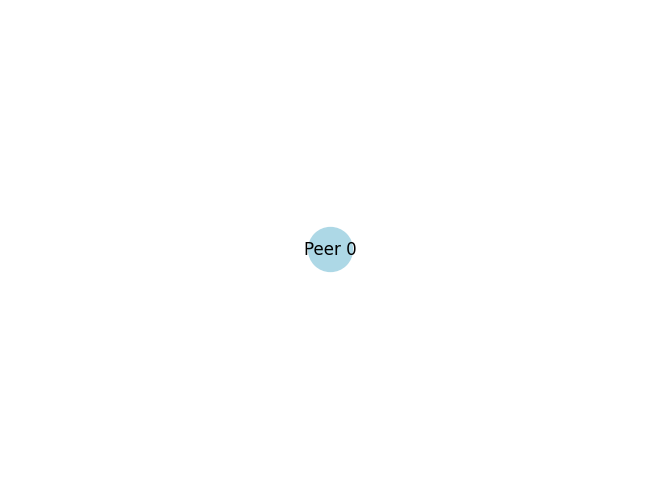

In [ ]:
def run_simulation(num_peers):
    env = simpy.Environment()
    peers = []
    global nofPeers
    nofPeers = num_peers

    Peer.file_size = random.uniform(50, 200)  # Assume file size is between 50MB and 200MB
    Peer.piece_size = Peer.file_size / TOTAL_PIECES
    # 创建多个对等节点
    for i in range(num_peers):
        upload_speed = random.uniform(1, 5)  # 随机上传带宽
        download_speed = random.uniform(1, 5)  # 随机下载带宽
        peer = Peer(env, i, upload_speed, download_speed)
        peers.append(peer)
 # Randomly assign file pieces to each peer (0 to 9 pieces)
        #if i == num_peers-1:
        if i == 0:
            # The first peer is the seeder, owning all pieces
            peer.file_pieces = set(range(TOTAL_PIECES))
        else:
            # Other peers get a random number of pieces
            num_pieces = random.randint(0, TOTAL_PIECES - 1)  # Random number of pieces from 0 to 9
            peer.file_pieces = set(random.sample(range(TOTAL_PIECES), num_pieces))

        peers.append(peer)

    # 连接所有对等节点
    for peer in peers:
        for other_peer in peers:
            if peer != other_peer:
                peer.add_peer(other_peer)


    # 第一个节点拥有所有文件块，作为种子节点
    # peers[0].file_pieces = set(range(TOTAL_PIECES))
    # print(f'Peer 0 是种子节点，拥有所有文件块: {peers[0].file_pieces}')

    # 运行模拟
    env.run(until=SIMULATION_TIME)

# 运行模拟
run_simulation(5)  # 创建5个对等节点
animation()

Time 1: Peer 1 requests file piece 0 from Peer 3
Time 1: Peer 1 requests file piece 1 from Peer 3
Time 1: Peer 1 requests file piece 2 from Peer 3
Time 1: Peer 1 requests file piece 3 from Peer 0
Time 1: Peer 1 requests file piece 6 from Peer 3
Time 1: Peer 1 requests file piece 7 from Peer 3
Time 1: Peer 1 requests file piece 9 from Peer 0
Time 1: Peer 2 requests file piece 0 from Peer 3
Time 1: Peer 2 requests file piece 1 from Peer 3
Time 1: Peer 2 requests file piece 2 from Peer 3
Time 1: Peer 2 requests file piece 4 from Peer 0
Time 1: Peer 2 requests file piece 5 from Peer 1
Time 1: Peer 2 requests file piece 8 from Peer 0
Time 1: Peer 3 requests file piece 3 from Peer 2
Time 1: Peer 4 requests file piece 0 from Peer 0
Time 1: Peer 4 requests file piece 1 from Peer 3
Time 1: Peer 4 requests file piece 2 from Peer 0
Time 1: Peer 4 requests file piece 3 from Peer 2
Time 1: Peer 4 requests file piece 6 from Peer 2
Time 1: Peer 4 requests file piece 7 from Peer 3
Time 1: Peer 4 reque

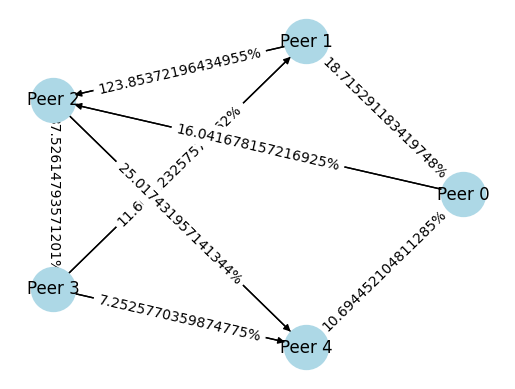

In [66]:
import random
import simpy
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

TOTAL_PIECES = 10  # 总共的文件块数 / Total number of file pieces
SIMULATION_TIME = 100  # 模拟的总时长 / Total simulation time

class Peer:
    def __init__(self, env, id, upload_speed, download_speed, animation):
        self.env = env
        self.id = id
        self.upload_speed = upload_speed  # 上传带宽 / Upload bandwidth
        self.download_speed = download_speed  # 下载带宽 / Download bandwidth
        self.file_pieces = set()  # 当前拥有的文件块 / File pieces currently owned
        self.peers = []  # 其他对等节点 / Other peers
        self.upload_resource = simpy.Resource(env, capacity=upload_speed)  # 上传带宽作为资源 / Upload bandwidth as a resource
        self.current_requests = 0  # 当前的请求数 / Current number of requests
        self.env.process(self.run())
        self.animation = animation  # 引入 Animation 对象

    def add_peer(self, peer):
        self.peers.append(peer)

    def request_piece(self, piece, target):
        """请求特定文件块并动态调整带宽 / Request a specific file piece and dynamically adjust bandwidth"""
        if piece in target.file_pieces:
            print(f'Time {self.env.now}: Peer {self.id} requests file piece {piece} from Peer {target.id}')

            with target.upload_resource.request() as req:
                target.current_requests += 1
                piece_size = Peer.piece_size
                downloaded = 0  # 初始化已下载部分 / Initialize downloaded portion

                while downloaded < piece_size:
                    number_of_requests = target.current_requests
                    available_bandwidth_per_request = target.upload_speed / max(1, number_of_requests)
                    data_per_step = available_bandwidth_per_request * 0.1  # 假设时间步为 0.1 秒

                    downloaded += data_per_step
                    yield self.env.timeout(0.1)

                    # 计算进度百分比
                    progress_percentage = (downloaded / piece_size) * 100
                    print(f'Time {self.env.now:.1f}: Peer {self.id} has downloaded {progress_percentage:.1f}% of file piece {piece}')

                    # 调用动画更新进度
                    self.animation.update_progress((target.id, self.id), progress_percentage)

                target.current_requests -= 1
                self.file_pieces.add(piece)
                print(f'Time {self.env.now:.1f}: Peer {self.id} completed download of file piece {piece}')
        else:
            print(f"Time {self.env.now:.1f}: Peer {self.id} found that Peer {target.id} no longer has file piece {piece}")

    def run(self):
        while True:
            if len(self.file_pieces) == TOTAL_PIECES:
                break
            yield self.env.timeout(1)

            missing_pieces = set(range(TOTAL_PIECES)) - self.file_pieces
            if not missing_pieces:
                break

            request_tasks = []
            requesting_pieces = set()

            for piece in missing_pieces:
                if piece in requesting_pieces:
                    continue
                shuffled_peers = self.peers[:]
                random.shuffle(shuffled_peers)

                for target_peer in shuffled_peers:
                    if piece in target_peer.file_pieces:
                        # 在找到目标节点后立即连接，并开始请求
                        self.animation.connect_peers(target_peer.id, self.id)
                        request_tasks.append(self.env.process(self.request_piece(piece, target_peer)))
                        requesting_pieces.add(piece)
                        break

            if request_tasks:
                yield self.env.all_of(request_tasks)

class Animation:
    def __init__(self, num_peers):
        self.num_peers = num_peers
        self.G = nx.DiGraph()
        self.pos = None
        self.edge_labels = {}
        self.fig, self.ax = plt.subplots()  # 创建画布
        self.updates = []  # 用于存储每一帧的更新（边和进度）

    def generate_peers(self):
        """生成Peer节点"""
        self.G.add_node(0, label='Peer 0')
        for i in range(1, self.num_peers):
            self.G.add_node(i, label=f'Peer {i}')
        self.pos = nx.circular_layout(self.G)

    def connect_peers(self, from_peer, to_peer):
        """为成功请求的两个Peer之间连线"""
        if not self.G.has_edge(from_peer, to_peer):
            self.G.add_edge(from_peer, to_peer, progress=0)  # 为两个成功请求的节点添加一条边
        self.edge_labels[(from_peer, to_peer)] = '0%'

    def update_progress(self, edge, progress):
        """更新指定边的进度，并在动画中展示"""
        from_peer, to_peer = edge
        if self.G.has_edge(from_peer, to_peer):
            self.G[from_peer][to_peer]['progress'] = progress
            self.edge_labels[(from_peer, to_peer)] = f'{progress}%'

        # 每次更新后将状态存储到 updates 列表中
        self.updates.append((edge, progress))

    def animate(self, i):
        """逐帧更新图像的动画函数"""
        self.ax.clear()

        # 绘制节点和边
        nx.draw(self.G, self.pos, with_labels=True, labels=nx.get_node_attributes(self.G, 'label'),
                node_color='lightblue', node_size=1000, ax=self.ax)
        nx.draw_networkx_edges(self.G, self.pos, ax=self.ax)

        # 逐帧应用进度更新
        if i < len(self.updates):
            edge, progress = self.updates[i]
            from_peer, to_peer = edge
            self.edge_labels[(from_peer, to_peer)] = f'{progress}%'

        # 绘制边上的进度标签
        nx.draw_networkx_edge_labels(self.G, self.pos, edge_labels=self.edge_labels, ax=self.ax)

    def save_animation(self, filename='animation.mp4', frames=10, interval=1000):


        # 如果需要倒序播放，生成倒序的帧列表

        # frame_list = list(range(frames - 1, -1, -1))
        frame_list = frames
         #[i for i in range(frames) if i % 5 == 0]


        # 创建动画
        anim = FuncAnimation(self.fig, self.animate, frames=frame_list, interval=interval, repeat=False)

        # 保存动画
        anim.save(filename, writer='ffmpeg')
        print(f"Animation saved as {filename}")

def run_simulation(num_peers):
    env = simpy.Environment()
    peers = []
    animation = Animation(num_peers)  # 创建动画实例

    Peer.file_size = random.uniform(10, 20)  # 假设文件大小在50MB到200MB之间
    Peer.piece_size = Peer.file_size / TOTAL_PIECES

    animation.generate_peers()

    # 创建多个对等节点
    for i in range(num_peers):
        upload_speed = random.uniform(1, 5)
        download_speed = random.uniform(1, 5)
        peer = Peer(env, i, upload_speed, download_speed, animation)  # 将动画传递给 Peer 类
        peers.append(peer)

        if i == 0:
            peer.file_pieces = set(range(TOTAL_PIECES))  # 种子节点拥有所有文件块
        else:
            num_pieces = random.randint(0, TOTAL_PIECES - 1)
            peer.file_pieces = set(random.sample(range(TOTAL_PIECES), num_pieces))

    # 连接所有对等节点
    for peer in peers:
        for other_peer in peers:
            if peer != other_peer:
                peer.add_peer(other_peer)

    # 运行模拟
    env.run(until=SIMULATION_TIME)

    # 保存动画为 mp4
    animation.save_animation(filename='animation.mp4', frames=100, interval=100)

# 运行模拟
run_simulation(5)  # 创建5个对等节点